In [1]:
import pandas as pd
import numpy as np
import random
from statistics import mean
import matplotlib.pyplot as plt
import copy

# Notes
1. Schedule entry structure is (grid electricity used, pv used, battery change, state of battery charge (soc), hour index)
2. Battery change is positive when charging and negative when discharging.
3. Fitness is cost, so lower cost (i.e. lower fitness) is better.
4. To set battery capacity and battery charge/discharge rate to 0, do not set to exactly 0 as this will result in errors when creating different offspring (see OneNote notes). Instead, set to a very small number such as 0.001. 
5. Schedules with a lower fitness get a higher mutation rate to explore the solution space, while schedules with a higher fitness get a lower mutation rate so that they are not disrupted by mutation. 
6. When graphing the battery change, each battery change value is multiplied by -1. This is to be consistant in the graph with the energy drawn from the grid and pv system (both positive). So by multiplying the battery change by -1, the energy drawn from the battery system is also positive.

# Parameters

In [2]:
start_date = '2022-06-03 00:00:00'
end_date = '2022-06-08 00:00:00'
max_iterations = 20
n_c = 0.2
n_e = 0.1
pop_size = 1000 # Have to have a high population size for crossover function to work properly
battery_cap = 200  # in kWh
battery_charge_discharge_rate = 100  # in kW
initial_soc = 0 # in kWh, the state of charge in the battery at the start of the time horizon
charge_discharge_percentage = random.uniform(0.5, 1)

# Data Preprocessing

In [3]:
df_prediction = pd.read_csv('Vyskov.csv')
df_consumption = pd.read_csv('historie-spotreb-elektrina.csv')
column_renames = {"Datum a čas": "Timestamp",
                  "Činná spotřeba hodinová (kWh)": "Hourly consumption (kWh)",
                  "Jalová spotřeba při spotřebě hodinová (kVAR)": "Reactive hourly consumption (kVAR)",
                  "Jalová dodávka při spotřebě hodinová (kVAR)": "Reactive supply hourly consumption (kVAR)"
                  }
df_consumption = df_consumption.rename(columns=column_renames)

prediction_column_rename = {"time_utc": "Timestamp", "production_prediction": "PV Energy Prediction (kWh)"}

df_prediction = df_prediction.rename(columns = prediction_column_rename)

df_consumption['Timestamp'] = pd.to_datetime(df_consumption['Timestamp'], format='%d.%m.%Y %H:%M')
df_prediction['Timestamp'] = pd.to_datetime(df_prediction['Timestamp'], format='%d/%m/%Y %H:%M')

In [4]:
df_consumption = df_consumption[["Timestamp", "Hourly consumption (kWh)"]]
df_prediction = df_prediction[["Timestamp", "PV Energy Prediction (kWh)"]]


df_combined = pd.merge(df_consumption, df_prediction, on="Timestamp")
df_combined.set_index('Timestamp', inplace=True)

In [5]:
# Define TOU rates for 24 hours (hour 0 = 0.23, hour 1 = 0.28, etc.)
tou_rates = {
    0: 0.23, 1: 0.28, 2: 0.27, 3: 0.25, 4: 0.22, 5: 0.20,   # 12 AM - 6 AM
    6: 0.30, 7: 0.35, 8: 0.40, 9: 0.45, 10: 0.42, 11: 0.38, # 6 AM - 12 PM
    12: 0.46, 13: 0.44, 14: 0.52, 15: 0.53, 16: 0.47, 17: 0.68, # 12 PM - 6 PM
    18: 0.64, 19: 0.50, 20: 0.45, 21: 0.35, 22: 0.29, 23: 0.22  # 6 PM - 12 AM
}


In [6]:
# Function to slice the DataFrame based on the start and end date
def get_time_horizon(df, start_date, end_date):
    # Ensure start_date and end_date are datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Slice the DataFrame using the loc function
    sliced_df = df.loc[start_date:end_date].copy()
    
    return sliced_df

# Get the sliced DataFrame for the defined time horizon
df = get_time_horizon(df_combined, start_date, end_date)

# Extract the hour and assign TOU rates using .loc to avoid the SettingWithCopyWarning
df.loc[:, 'hour'] = df.index.hour
df.loc[:, 'TOU (€/kWh)'] = df['hour'].map(tou_rates)

# Drop the 'hour' column as it's no longer needed
df.drop(columns=['hour'], inplace=True)

df.head(60)

,Hourly consumption (kWh),PV Energy Prediction (kWh),TOU (€/kWh)
Timestamp,,,
2022-06-03 00:00:00,98,0.000607,0.23
2022-06-03 01:00:00,78,0.000607,0.28
2022-06-03 02:00:00,81,0.000607,0.27
2022-06-03 03:00:00,87,0.000607,0.25
2022-06-03 04:00:00,52,0.399600,0.22
2022-06-03 05:00:00,91,6.550200,0.20
2022-06-03 06:00:00,177,15.530400,0.30
2022-06-03 07:00:00,208,17.878418,0.35
2022-06-03 08:00:00,350,35.947800,0.40


# GA functions

In [7]:
# Function to initialise a single schedule
def init_schedule(df):
    schedule = []
    soc = initial_soc  # Initial state of charge of the battery
    
    for t in range(len(df)):
        timestamp = df.index[t]
        hourly_consumption = df['Hourly consumption (kWh)'][t]
        pv_available = df['PV Energy Prediction (kWh)'][t]
        tou_rate = df['TOU (€/kWh)'][t]
        
        # Generate a random floats
        random_roll = random.random()
        
        # If the TOU is low, store the majority of the pv energy and use only some of it now, with a high probability.
        # Update soc with this pv energy that has gone into the battery.
        if tou_rate < 0.6 and random_roll < 0.9:
            pv_charge_percentage = random.uniform(0.7, 1)
        else:
            # If the TOU is high, use majority of the PV now and store only some of it.
            pv_charge_percentage = random.uniform(0, 0.3)
            
        
        # Determine the pv energy charge amount (kWh)
        pv_charge_amount = pv_available * pv_charge_percentage


        # The PV charge amount battery is restricted by the charge/discharge rate and the remaining capacity in the battery
        pv_into_battery = min(battery_charge_discharge_rate, battery_cap - soc, pv_charge_amount)


        # Remainig pv energy to use now
        pv_use_now = min(hourly_consumption, (pv_available - pv_into_battery))
            
        
        if pv_into_battery == pv_charge_amount:
            # This means that there is more room for charging the battery as pv_into_battery < battery_charge_discharge_rate and remaining capacity in battery
            battery_charging_potential = min(battery_charge_discharge_rate, battery_cap - soc) - pv_charge_amount
        else:
            battery_charging_potential = 0
            
        # Use this remaining battery charging potential with grid energy during low TOU
        if tou_rate < 0.6 and random_roll < 0.9:
            
            # battery_change_not_pv is the change in the battery charge for this timestep not including the pv into the battery
            battery_change_not_pv = battery_charging_potential * charge_discharge_percentage
            battery_change = battery_change_not_pv + pv_into_battery
        else:
            # During high TOU, discharge the battery
            # Determine the discharge rate. Either the maximum discharge rate or whatever is left in the battery or whatever the hourly consumption is less what has been used by PV
            discharge_rate = max(-battery_charge_discharge_rate, -soc, -hourly_consumption + pv_use_now)

            battery_change_not_pv = charge_discharge_percentage * discharge_rate
            battery_change = battery_change_not_pv + pv_into_battery

        # Update SOC
        soc += battery_change

        # Ensure SOC stays within limits
        #soc = max(0, min(battery_cap, soc))
        if soc < 0 or soc > battery_cap:
            print(f"ERROR: SOC OUT OF BOUNDS")

        # Determine grid usage
        grid_usage = max(0, hourly_consumption - pv_use_now + battery_change)

        # Append the tuple (grid_usage, pv_used, battery_change, soc, hour) to the schedule
        schedule.append((grid_usage, pv_use_now, battery_change, soc, t, pv_into_battery, battery_change_not_pv))
        
        if abs(pv_available - pv_into_battery - pv_use_now) > 1e-3:
            print(f"ERROR: PV AVAILABLE NOT EQUAL TO PV INTO BATTERY AND PV USED NOW")
            print(f"SOC = {soc}, PV available = {pv_available}, PV into battery = {pv_into_battery}, pv use now = {pv_use_now}")
            
        # Debugging
        if t == 0:
            previous_soc = initial_soc
        else:
            previous_soc = schedule[t-1][3]
        
        if previous_soc + battery_change != soc:
            print(f"ERROR IN INITIALISATION FUNCTION, PREVIOUS SOC + BATTERY CHANGE != CURRENT SOC")
            print(f" Hour = {t}, Previous SOC = {previous_soc:.3f}, Battery Change = {battery_change:.3f}, Current SOC = {soc:.3f}")
        
        #print(f"TOU = {tou_rate}, Hour = {t}, Total Battery Change = {battery_change:.3f}, Battery change from PV = {pv_into_battery:.3f}, Battery change not PV = {battery_change_not_pv:.3f}")
        
        
        if abs(hourly_consumption - (grid_usage + pv_use_now - battery_change)) > 1e-3:
            print("ERROR IN INITIALISATION FUNCTION, ENERGY IMBALANCE")
            print(f"Hour = {t}, tou rate = {tou_rate}, hourly consumption = {hourly_consumption}, Grid usage = {grid_usage}, PV used = {pv_use_now}, battery change = {battery_change}")
        #print(f"Hour = {t}, Grid Usage = {grid_usage:.2f} kWh, PV used = {pv_used:.2f} kWh, Battery Change = {battery_change:.2f}, SOC = {soc:.2f}")
        
        if battery_change > battery_charge_discharge_rate:
            print(f"Error in initialisation function, battery change invalid")

    return schedule

In [8]:
# Function to initialise the population
def init_population(df, pop_size):
    population = [init_schedule(df) for _ in range(pop_size)]
    return population

In [9]:
# Fitness function to evaluate a schedule
def schedule_fitness(schedule, df):
    tou_rates = df['TOU (€/kWh)'].values
    total_cost = 0
    for (grid_usage, pv_used, battery_change, soc, hour, pv_into_battery, battery_change_not_pv) in schedule:
        total_cost += grid_usage * tou_rates[hour]
    return total_cost

In [10]:
# Example usage with a population and corresponding TOU rates
def evaluate_population(population, df):
    tou_rates = df['TOU (€/kWh)'].values
    fitness_values = []
    for individual in population:
        fitness_values.append(schedule_fitness(individual, df))
    average_fitness = mean(fitness_values)
    return fitness_values, average_fitness

In [11]:
# Selection function to select the top n individuals
def select_top_n(population, df, n):
    fitnesses, _ = evaluate_population(population, df)
    # Sorts the population indices in ascending order according to fitness
    sorted_indices = np.argsort(fitnesses)
    
    # Select the top n individuals
    best_schedules = [population[i] for i in sorted_indices[:n]]
    
    return best_schedules

In [12]:
def resolve_conflict(offspring, df):
    schedule_counter = 0
    for idx, schedule in enumerate(offspring):
        schedule_counter += 1
        #print(f"Schedule = {schedule_counter}")
        for i in range(len(schedule)):
            grid_usage, pv_use_now, current_battery_change, current_soc, hour_idx, pv_into_battery, battery_change_not_pv = schedule[i]

            if i == 0:
                previous_soc = initial_soc
            else:
                previous_soc = schedule[i-1][3]

            # Update the soc after crossover and mutation
            new_soc = previous_soc + current_battery_change
            schedule[i] = (grid_usage, pv_use_now, current_battery_change, new_soc, hour_idx, pv_into_battery, battery_change_not_pv)
            
            #print(f"Hour before update = {hour_idx}")

            # Check if SOC is out of bounds
            if new_soc < 0 or new_soc > battery_cap:
                new_soc = previous_soc  # Reset SOC to previous valid SOC

                # Fetch data for this hour
                hourly_consumption = df['Hourly consumption (kWh)'][hour_idx]
                pv_available = df['PV Energy Prediction (kWh)'][hour_idx]
                tou_rate = df['TOU (€/kWh)'][hour_idx]

                # Generate random float to decide mutation behavior
                random_roll = random.random()

                # Adjust battery charge behavior based on TOU rate
                if tou_rate < 0.6 and random_roll < 0.9:
                    pv_charge_percentage = random.uniform(0.7, 1)
                else:
                    pv_charge_percentage = random.uniform(0, 0.3)

                # Calculate PV charge amount and energy into the battery
                pv_charge_amount = pv_available * pv_charge_percentage
                pv_into_battery = min(battery_charge_discharge_rate, battery_cap - new_soc, pv_charge_amount)

                # Use remaining PV energy for immediate consumption
                pv_use_now = min(hourly_consumption, (pv_available - pv_into_battery))

                # Calculate remaining charging potential if needed
                battery_charging_potential = max(0, min((battery_cap - new_soc - pv_into_battery), battery_charge_discharge_rate - pv_into_battery))

                # Update battery charge or discharge
                if tou_rate < 0.6 and random_roll < 0.9:
                    battery_change_not_pv = battery_charging_potential * charge_discharge_percentage
                    battery_change = battery_change_not_pv + pv_into_battery
                else:
                    discharge_rate = max(-battery_charge_discharge_rate, -new_soc, -hourly_consumption + pv_use_now)
                    battery_change_not_pv = charge_discharge_percentage * discharge_rate
                    battery_change = battery_change_not_pv + pv_into_battery

                # Update new SOC after adjustment
                new_soc = previous_soc + battery_change

                # Ensure SOC is within bounds after adjustment
                #new_soc = max(0, min(new_soc, battery_cap))

                # Calculate grid usage based on remaining hourly consumption
                grid_usage = max(0, hourly_consumption - pv_use_now + battery_change)

                # Now update the schedule in place by reassigning the tuple
                schedule[i] = (grid_usage, pv_use_now, battery_change, new_soc, hour_idx, pv_into_battery, battery_change_not_pv)
                if battery_change > battery_charge_discharge_rate:
                    print(f"ERROR IN RESOLVE CONFLICT, BATTERY CHANGE Invalid")
                    #print(f"Battery charging potential = {battery_charging_potential}")
                    print(f"HOUR = {hour_idx}, Battery change = {battery_change}, battery change not pv = {battery_change_not_pv}, pv into battery = {pv_into_battery}")
                
                if new_soc > battery_cap or new_soc < 0:
                    print(f"Resolved new soc is still invalid = {new_soc:.3f}, previous soc = {previous_soc:.3f}, Battery change not pv = {battery_change_not_pv:.3f}, pv into battery = {pv_into_battery:.3f}")

            
            # If the current soc changes, update all subsequent SOC values
            
            if current_soc != new_soc:
                #print(f"Updating all susequent soc values after hour {hour_idx}")
                #print(f"New soc = {new_soc}")
                for t in range(hour_idx + 1, len(schedule)):
                    #print(f"Updating all subsequent soc values")
                    grid, pv_use_now, battery_change, soc, hour_index, pv_into_battery, battery_change_not_pv = schedule[t]
                    previous_soc = schedule[t-1][3]
                    #print(f"Hour = {t}, previous soc = {previous_soc}, current battery change = {battery_change}")
                    updated_new_soc = previous_soc + battery_change
                    #updated_new_soc = max(0, min(updated_new_soc, battery_cap))  # Ensure bounds

                    # Now update the tuple in the schedule in place
                    schedule[t] = (grid, pv_use_now, battery_change, updated_new_soc, hour_index, pv_into_battery, battery_change_not_pv)

                    if battery_change > battery_charge_discharge_rate:
                        print(f"ERROR IN RESOLVE CONFLICT AFTER UPDATE, BATTERY CHANGE TOO HIGH")
                        print(f"Hour = {t}, Battery change = {battery_change}, battery change not pv = {battery_change_not_pv}, pv into battery = {pv_into_battery}")



    return offspring


In [13]:
def crossover(population, best_solutions, n_c, n_e, num_points=2):
    
    offspring = copy.deepcopy(best_solutions)
    # Number of child solutions to generate from best_solutions
    iter_count = len(population) * (n_c + n_e)
    max_attempts = 5
    
    
    while len(offspring) < iter_count:
        parent1, parent2 = random.sample(best_solutions, 2)
        attempts = 0
        # print(f"Length of best solutions = {len(best_solutions)}")
        while parent1 == parent2 and attempts < max_attempts:
            print(f"ERROR: BOTH PARENTS EQUAL, PICKING NEW PARENT (Attempt {attempts + 1})")
            parent2 = random.choice(best_solutions)
            attempts += 1
        
        
        # Generate unique crossover points
        crossover_points = sorted(np.random.choice(range(1, len(parent1) - 1), num_points, replace=False))
        crossover_points = [0] + crossover_points + [len(parent1)]  # Add start and end points
        #print(f"Crossover points are {crossover_points}")
    
        offspring1, offspring2 = [], []

        for i in range(len(crossover_points) - 1):
            start, end = crossover_points[i], crossover_points[i + 1]
            if i % 2 == 0:
                offspring1.extend(parent1[start:end])
                offspring2.extend(parent2[start:end])
            else:
                offspring1.extend(parent2[start:end])
                offspring2.extend(parent1[start:end])
        

       
        # Attempting to add two offspring to the list of best solutions
        if offspring1 not in offspring:
            offspring.append(offspring1)
            #print(f"Offspring 1 is not in best_solutions")
        #else:
            #print(f"ERROR: Offspring 1 is in best_solutions")

        if offspring2 not in offspring:
            offspring.append(offspring2)
            #print(f"Offspring 2 is not in best_solutions")
        #else:
            #print(f"ERROR: Offspring 2 is in best_solutions")
        
        
        
    for schedule in offspring:
        for i in range(len(schedule)):
            grid_usage, pv_use_now, battery_change, soc, hour, pv_into_battery, battery_change_not_pv = schedule[i]
            if battery_change > battery_charge_discharge_rate:
                print(f"Battery change is too high after offspring {battery_change}")
    return offspring
        

In [14]:
def mutation(population):
    _, average_fitness = evaluate_population(population, df)
    #print(f"Average fitness = {average_fitness:.2f}")
    # For debugging
    schedule_number = 0
    num_low_fit, num_good_fit = 0, 0
    mutated_battery_change = None
    
    # debugging
    pop_before_mutation = population
    
    for schedule in population:
        
        schedule_number += 1
        '''
        schedule_before_mutation = schedule
        schedule_fitness_before_mutation = schedule_fitness(schedule_before_mutation, df)
        print(f"Schedule {schedule_number} fitness before mutation = {schedule_fitness_before_mutation}")
        '''
        
        fitness = schedule_fitness(schedule, df)
        if fitness < average_fitness:
            schedule_mutation_rate = 0.2
            entry_mutation_rate = 0.15
        else:
            schedule_mutation_rate = 0.25
            entry_mutation_rate = 0.2
        
        random_roll_1 = random.random()
        
        if random_roll_1 <= schedule_mutation_rate:
            for i in range(len(schedule)):
                if i == 0:
                    previous_soc = initial_soc
                else:
                    previous_soc = schedule[i-1][3]
                grid_usage, pv_use_now, battery_change, soc, hour, pv_into_battery, battery_change_not_pv = schedule[i]
                hourly_consumption = df['Hourly consumption (kWh)'][i]

                if previous_soc + battery_change != soc:
                    #print(f"Error before mutation function, previous soc + battery change != soc")
                    #print(f"Previous Soc = {previous_soc}, battery change = {battery_change}, soc = {soc}")
                    updated_soc = previous_soc + battery_change
                else:
                    updated_soc = soc
                schedule[i] = grid_usage, pv_use_now, battery_change, updated_soc, hour, pv_into_battery, battery_change_not_pv
                
                
                if updated_soc < 0 or updated_soc > battery_cap:
                    updated_soc = previous_soc
                    # Must update the battery usage
                    
                    # Fetch data for this hour
                    hourly_consumption = df['Hourly consumption (kWh)'][hour]
                    pv_available = df['PV Energy Prediction (kWh)'][hour]
                    tou_rate = df['TOU (€/kWh)'][hour]

                    # Generate random float to decide mutation behavior
                    random_roll = random.random()

                    # Adjust battery charge behavior based on TOU rate
                    if tou_rate < 0.6 and random_roll < 0.9:
                        pv_charge_percentage = random.uniform(0.7, 1)
                    else:
                        pv_charge_percentage = random.uniform(0, 0.3)

                    # Calculate PV charge amount and energy into the battery
                    pv_charge_amount = pv_available * pv_charge_percentage
                    pv_into_battery = min(battery_charge_discharge_rate, battery_cap - updated_soc, pv_charge_amount)

                    # Use remaining PV energy for immediate consumption
                    pv_use_now = min(hourly_consumption, (pv_available - pv_into_battery))

                    # Calculate remaining charging potential if needed
                    battery_charging_potential = max(0, min((battery_cap - updated_soc - pv_into_battery), battery_charge_discharge_rate - pv_into_battery))

                    # Update battery charge or discharge
                    if tou_rate < 0.6 and random_roll < 0.9:
                        battery_change_not_pv = battery_charging_potential * charge_discharge_percentage
                        battery_change = battery_change_not_pv + pv_into_battery
                    else:
                        discharge_rate = max(-battery_charge_discharge_rate, -updated_soc, -hourly_consumption + pv_use_now)
                        battery_change_not_pv = charge_discharge_percentage * discharge_rate
                        battery_change = battery_change_not_pv + pv_into_battery

                    # Update new SOC after adjustment
                    updated_soc = previous_soc + battery_change

                    # Ensure SOC is within bounds after adjustment
                    #new_soc = max(0, min(new_soc, battery_cap))

                    # Calculate grid usage based on remaining hourly consumption
                    grid_usage = max(0, hourly_consumption - pv_use_now + battery_change)

                    # Now update the schedule in place by reassigning the tuple
                    schedule[i] = (grid_usage, pv_use_now, battery_change, updated_soc, hour, pv_into_battery, battery_change_not_pv)
        
        
                random_roll_2 = random.random()
                
                if random_roll_2 <= entry_mutation_rate:
                    #print(f"Mutation is taking place for schedule {schedule_number}")
                    mutation_percentage = random.uniform(-0.5, 0.5)
                    mutation_amount = battery_change_not_pv * mutation_percentage
                    mutated_battery_change_not_pv = battery_change_not_pv + mutation_amount
                    mutated_battery_change = pv_into_battery + mutated_battery_change_not_pv
                    
                    mutated_soc = previous_soc + mutated_battery_change
                    charge_amount = 0

                    
                    if mutated_battery_change > 0 and (mutated_battery_change > battery_charge_discharge_rate or (mutated_battery_change + previous_soc) > battery_cap) :
                        #print(f"Invalid mutated battery charge = {mutated_battery_change}")
                        # How much room is left to charge the battery
                        charge_potential = max(0, (min(battery_charge_discharge_rate - pv_into_battery, battery_cap - previous_soc - pv_into_battery)))
                        #print(f"PV into battery = {pv_into_battery}, Soc = {soc}, charge potential = {charge_potential}")
                        
                        charge_percentage = random.uniform(0, 1)
                        mutated_battery_change_not_pv = charge_potential * charge_percentage
                        
                        # Update mutated_battery_change
                        mutated_battery_change = mutated_battery_change_not_pv + pv_into_battery
                        
                        
                        # Update mutated_soc
                        mutated_soc = previous_soc + mutated_battery_change
                        if mutated_soc < 0 or mutated_soc > battery_cap:
                            print(f"Still invalid mutated soc after adjusting battery charge. Mutated soc = {mutated_soc}")
                        
                        
                    
                    if mutated_battery_change < 0 and (mutated_battery_change < -battery_charge_discharge_rate or (mutated_battery_change + previous_soc) < 0):
                        #print(f"Invalid mutated battery discharge = {mutated_battery_change}")
                        # How much room is left for the battery to discharge
                        discharge_potential = max(-battery_charge_discharge_rate, -updated_soc)
                        
                        discharge_percentage = random.uniform(0, 1)
                        mutated_battery_change_not_pv = discharge_potential * discharge_percentage
                        
                        mutated_battery_change = mutated_battery_change_not_pv + pv_into_battery
                        
                        mutated_soc = previous_soc + mutated_battery_change
                        if mutated_soc < 0 or mutated_soc > battery_cap:
                            print(f"Still invalid soc after adjusting battery discharge")
                            print(f"Invalid soc = {mutated_soc}")
                        
                    '''
                    if mutated_soc < 0 or mutated_soc > battery_cap:
                        print(f"Invalid mutated soc = {mutated_soc}")
                        print(f"Previous soc = {previous_soc}, Charge Amount = {charge_amount}, Mutated battery change = {mutated_battery_change}")
                    '''
                    #print(f"Original soc = {soc}, Mutated SOC = {mutated_soc}")    
                    grid_usage = max(0, hourly_consumption - pv_use_now + mutated_battery_change)
                    schedule[i] = (grid_usage, pv_use_now, mutated_battery_change, mutated_soc, hour, pv_into_battery, mutated_battery_change_not_pv)
                    if mutated_battery_change > battery_charge_discharge_rate:
                        print(f"ERROR IN MUTATATION FUNCTION, BATTERY CHANGE INVALID")

        '''
        # Debugging
        mutated_schedule = schedule
        mutated_schedule_fitness = schedule_fitness(mutated_schedule, df)
        print(f"Mutated Schedule {schedule_number} fitness = {mutated_schedule_fitness}")
        '''        

    
        for i in range(len(schedule)):
            grid_usage, pv_use_now, battery_change, soc, hour, pv_into_battery, battery_change_not_pv = schedule[i]
        
            if battery_change > battery_charge_discharge_rate:
                print(f"When returning pop from mutation, found that battery change is invalid = {battery_change} for hour {i}")
                if mutated_battery_change and battery_change == mutated_battery_change:
                    print(f"This invalid battery change underwent mutation")
                else:
                    print(f"This invalid battery change did not undergo mutation")
    return population

# Running GA

In [15]:
def extract_best_schedule(population, fitness_values):
    # Find the best schedule based on the minimum fitness value
    best_index = np.argmin(fitness_values)
    best_schedule = population[best_index]
    return best_schedule

In [16]:
def prepare_plot_data(best_schedule, df):
    timestamps = df.index
    hourly_consumption = df['Hourly consumption (kWh)']
    grid_usage = [entry[0] for entry in best_schedule]
    pv_usage = [entry[1] for entry in best_schedule]
    battery_soc = [entry[3] for entry in best_schedule]
    battery_change = [entry[2] for entry in best_schedule]
    
    # For graphing, multiply the battery_change by -1 so that in the graph, a positive value for the battery_change profile is 
    # the battery discharging (same as grid discharging) and negative shows the battery charging
    battery_change = [-1 * value for value in battery_change]
    return timestamps, grid_usage, pv_usage, battery_soc, battery_change, hourly_consumption


In [17]:
def plot_schedule_battery_change(timestamps, grid_usage, pv_usage, battery_change, hourly_consumption):
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, grid_usage, label='Grid Usage (kWh)', color='blue')
    plt.plot(timestamps, pv_usage, label='PV Usage (kWh)', color='orange')
    plt.plot(timestamps, battery_change, label='Battery Charge and Discharge Profile (kWh)', color='red')
    plt.plot(timestamps, hourly_consumption, label='Energy Consumption (kWh)', color='black')
    plt.xlabel('Time')
    plt.ylabel('Energy (kWh)')
    plt.title('Electricity Usage from Grid, Battery and PV System')
    plt.legend(loc='upper right')
    plt.ylim(-100, 600)  # Set y-axis limits
    plt.grid(True)
    plt.show()

In [18]:
def plot_schedule_battery_soc(timestamps, grid_usage, pv_usage, battery_soc, hourly_consumption):
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, grid_usage, label='Grid Usage (kWh)', color='blue')
    plt.plot(timestamps, pv_usage, label='PV Usage (kWh)', color='orange')
    plt.plot(timestamps, battery_soc, label='Battery State of Charge (kWh)', color='green')
    plt.plot(timestamps, hourly_consumption, label='Energy Consumption (kWh)', color='black')
    plt.xlabel('Time')
    plt.ylabel('Energy (kWh)')
    plt.title('Electricity Usage from Grid, Battery and PV system')
    plt.legend(loc='upper right')
    plt.ylim(0, 600)  # Set y-axis limits
    plt.grid(True)
    plt.show()

In [19]:
def save_best_schedule_to_csv(best_schedule, original_df, filename):
    # Create a pandas DataFrame from the best schedule
    df = pd.DataFrame(best_schedule, columns=['Grid Usage (kWh)', 'PV Used during this timestep (kWh)', 'Battery Charge/Discharge (kWh)', 'Battery State of Charge (kWh)', 'Hour', 'PV into Battery (kWh)', 'Battery Change not including PV (kWh)'])
    
    # Drop the 'Hour' column as it is not required in the CSV file
    df = df.drop(columns=['Hour'])
    df['Timestamp'] = original_df.index
    df.set_index('Timestamp', inplace=True)
    df['Hourly Consumption (kWh)'] = original_df['Hourly consumption (kWh)']
    df['TOU rate (€/kWh)'] = original_df['TOU (€/kWh)']
    df['Hourly Cost (€)'] = df['TOU rate (€/kWh)'] * df['Grid Usage (kWh)']
    df['Energy Balance'] = df['Hourly Consumption (kWh)'] + df['Battery Charge/Discharge (kWh)'] - df['Grid Usage (kWh)'] - df['PV Used during this timestep (kWh)']
    df['Energy Balance'] = df['Energy Balance'].round(4)
    
    # Save the DataFrame to a CSV file
    df.to_csv(filename)

In [20]:
def run(df, n_c, n_e, max_iterations):
    tou_rates = df['TOU (€/kWh)'].values
    P = init_population(df, pop_size)
    #print(f"Length of initial population = {len(P)}")
    initial_fitnesses, _ = evaluate_population(P, df)
    #print(f"Initial fitnesses = {initial_fitnesses[:20]}")
    
    for iteration in range(max_iterations):
        print(f"-----"* 20)
        print(f"Beginning of iteration {iteration}")
        population_fitnesses, _ = evaluate_population(P, df)
        best_solutions = select_top_n(P, df, int(len(P) * n_e))
        
        '''
        # Debugging 
        sched_counter = 0
        for solution in best_solutions:
            sched_counter += 1
            fitness_of_schedule = schedule_fitness(solution, df)
            print(f"Schedule number = {sched_counter}, fitness = {fitness_of_schedule}")
        
        print(f"Length of best solutions = {len(best_solutions)}")
        '''
        
        # Offspring includes the best_solutions (parents) and the additional offspring
        offspring = crossover(P, best_solutions, n_c, n_e)
        #print(f"Length of offspring = {len(offspring)}")
        #print(f"Length of best solutions after offspring = {len(best_solutions)}")
        print(f"Offspring created")
        
        #P_resolved = resolve_conflict(offspring, df)
        #print(f"Length of P_resolved = {len(P_resolved)}")

        # Fill up the next population with random solutions
        if len(offspring) < pop_size:
            offspring += init_population(df, pop_size-len(offspring))
        print(f"Random solutions added to offspring")
       

        # Create elite solutions
        #elite_solutions = select_top_n(P_resolved, df, num_elites)

        # Population without elites will be mutated
        offspring_less_best = ([sol for sol in offspring if sol not in best_solutions])
        
        print(f"Best Solutions removed from offspring")

        mutated_P = mutation(offspring_less_best)
        print(f"Offspring less best population mutated")

        P_resolved = resolve_conflict(mutated_P, df)
        print(f"Mutated population conflicts resolved")

        P = P_resolved + copy.deepcopy(best_solutions)
        print(f"Resolved conflict population combined with best solutions to form generation final population")
        
        
        # Evaluate fitness scores of next generation for tracking fitness scores
        next_gen_fitness_scores, _ = evaluate_population(P, df)
        print(f"Population fitnesses evaluated")
        
            
            
        best_fitness_score = min(next_gen_fitness_scores)
        print(f"Iteration {iteration}, Best fitness = {best_fitness_score}")
        
    best_overall_score = min(next_gen_fitness_scores)
    
    best_schedule = extract_best_schedule(P, next_gen_fitness_scores)
    save_best_schedule_to_csv(best_schedule, df, 'SPOT_TOU_NON_GREEDY_03_06_2022_to_08_06_2022_200kWh.csv')
    timestamps, grid_usage, pv_usage, battery_soc, battery_change, hourly_consumption = prepare_plot_data(best_schedule, df)
    plot_schedule_battery_change(timestamps, grid_usage, pv_usage, battery_change, hourly_consumption)
    plot_schedule_battery_soc(timestamps, grid_usage, pv_usage, battery_soc, hourly_consumption)
    
    for entry in best_schedule:
        tou_rate = df['TOU (€/kWh)'][entry[4]]
        pv_available = df['PV Energy Prediction (kWh)'][entry[4]]
        hourly_consumption = df['Hourly consumption (kWh)'][entry[4]]
        #print(f"Hour {entry[4]}: TOU rate = {tou_rate} Hourly Consumption = {hourly_consumption}, Grid Usage = {entry[0]:.2f} kWh, PV Used = {entry[1]:.2f} kWh, "
          #f"Battery Change = {entry[2]:.2f} kWh, SOC = {entry[3]:.2f} kWh")
        #print(f"PV available = {pv_available:.5f}, PV used now = {entry[1]:.5f}, PV into battery = {entry[5]:.5f}")
        #print(f"Entry = {entry[5]}")
        print(f"Hour = {entry[4]}, TOU rate = {tou_rate}, Hourly Consumption = {hourly_consumption}, Grid Usage (into battery + used now) = {entry[0]:.3f}, PV used = {entry[1]:.3f}, PV into battery = {entry[5]:.3f}, pv available = {pv_available}, battery change not pv = {entry[6]:.3f}, Total Battery change = {entry[2]:.3f}, SOC = {entry[3]:.3f}")

    
    print(f"Best score after {max_iterations} Iterations = {best_overall_score}")
         

----------------------------------------------------------------------------------------------------
Beginning of iteration 0
Offspring created
Random solutions added to offspring
Best Solutions removed from offspring
Offspring less best population mutated
Mutated population conflicts resolved
Resolved conflict population combined with best solutions to form generation final population
Population fitnesses evaluated
Iteration 0, Best fitness = 8065.151796012602
----------------------------------------------------------------------------------------------------
Beginning of iteration 1
Offspring created
Random solutions added to offspring
Best Solutions removed from offspring
Offspring less best population mutated
Mutated population conflicts resolved
Resolved conflict population combined with best solutions to form generation final population
Population fitnesses evaluated
Iteration 1, Best fitness = 8054.15491377182
---------------------------------------------------------------------

Offspring less best population mutated
Mutated population conflicts resolved
Resolved conflict population combined with best solutions to form generation final population
Population fitnesses evaluated
Iteration 17, Best fitness = 7912.014958454856
----------------------------------------------------------------------------------------------------
Beginning of iteration 18
Offspring created
Random solutions added to offspring
Best Solutions removed from offspring
Offspring less best population mutated
Mutated population conflicts resolved
Resolved conflict population combined with best solutions to form generation final population
Population fitnesses evaluated
Iteration 18, Best fitness = 7910.621879891331
----------------------------------------------------------------------------------------------------
Beginning of iteration 19
Offspring created
Random solutions added to offspring
Best Solutions removed from offspring
Offspring less best population mutated
Mutated population confli

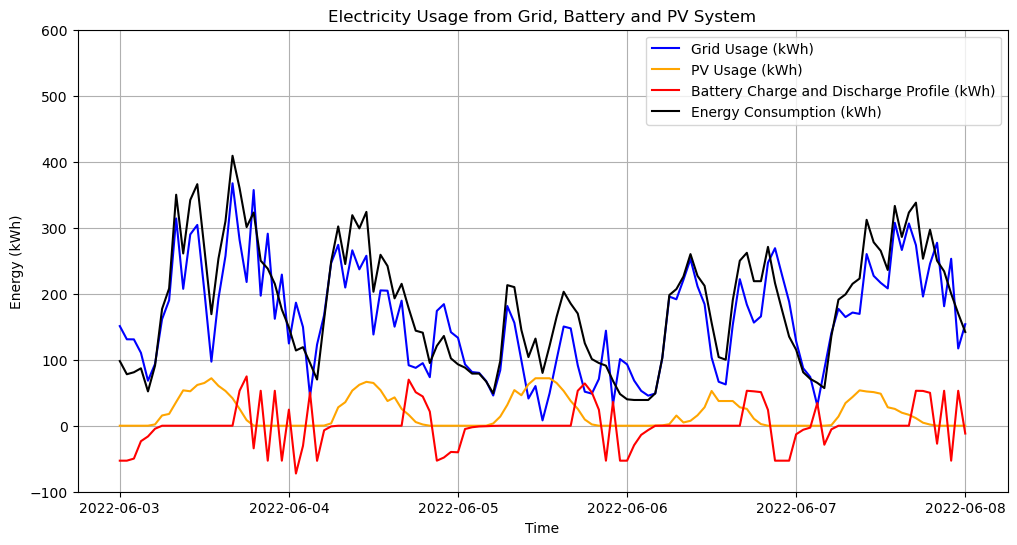

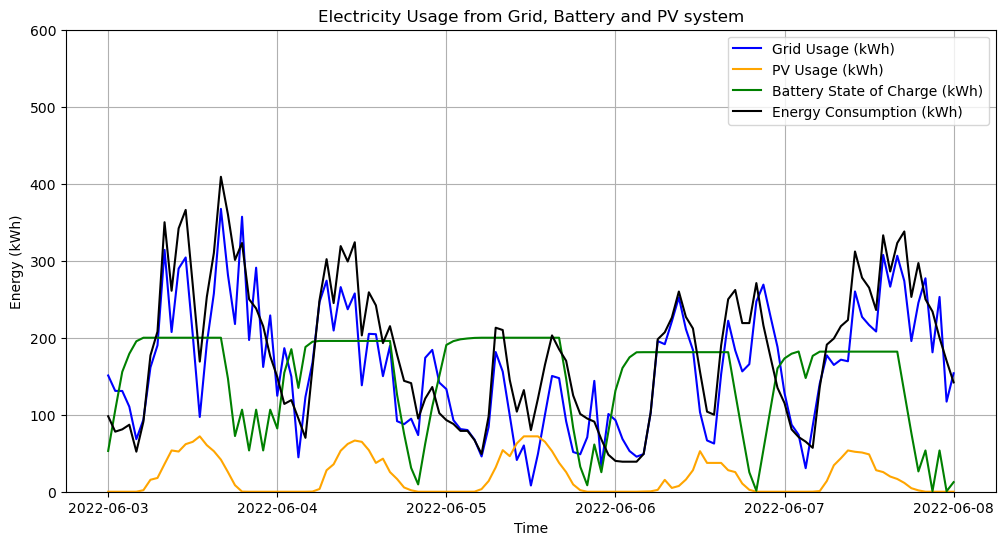

Hour = 0, TOU rate = 0.23, Hourly Consumption = 98, Grid Usage (into battery + used now) = 150.960, PV used = 0.000, PV into battery = 0.000, pv available = 0.000606793, battery change not pv = 52.960, Total Battery change = 52.960, SOC = 52.960
Hour = 1, TOU rate = 0.28, Hourly Consumption = 78, Grid Usage (into battery + used now) = 130.960, PV used = 0.000, PV into battery = 0.001, pv available = 0.000606793, battery change not pv = 52.960, Total Battery change = 52.960, SOC = 105.920
Hour = 2, TOU rate = 0.27, Hourly Consumption = 81, Grid Usage (into battery + used now) = 130.825, PV used = 0.000, PV into battery = 0.001, pv available = 0.000606793, battery change not pv = 49.824, Total Battery change = 49.825, SOC = 155.745
Hour = 3, TOU rate = 0.25, Hourly Consumption = 87, Grid Usage (into battery + used now) = 110.438, PV used = 0.000, PV into battery = 0.001, pv available = 0.000606793, battery change not pv = 23.437, Total Battery change = 23.438, SOC = 179.183
Hour = 4, TOU

In [21]:
run(df, n_c, n_e, max_iterations)